# 7-DAY-LSTM
### By Siddhartha Pachhai

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import requests
import json
from pandas.io.json import json_normalize
import io
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This is for MacOS

## Select Ticker

In [3]:
API = "Your API Key"
stock_id = "AMZN"

In [4]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+str(stock_id)+"&apikey="+str(API)+"&datatype=csv&outputsize=full"

In [5]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

Using TensorFlow backend.


In [6]:
D = requests.get(url).content

In [7]:
rawData = pd.read_csv(io.StringIO(D.decode('utf-8')))

In [8]:
len(rawData)

5031

In [9]:
rawData.head(1)

,timestamp,open,high,low,close,volume
0,2019-09-17,1807.08,1823.99,1804.2736,1822.55,1811633


In [10]:
rawData = rawData.iloc[::-1]
rawData = rawData.reset_index(drop = True)
rawData.head(1)

,timestamp,open,high,low,close,volume
0,1999-09-20,63.688,65.0,62.688,62.75,5957100


In [11]:
# function for min-max normalization of stock, 
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [12]:
# function for min-max normalization of stock
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [13]:
# choose one stock
df_stock = rawData#df[df.symbol == ticker].copy()
df_stock.drop(['timestamp'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)
df_stock_norm.describe()

df_stock.columns.values =  ['open', 'high', 'low', 'close']


,open,high,low,close
count,5031.000000,5031.000000,5031.000000,5031.000000
mean,0.162714,0.163399,0.162899,0.162547
std,0.241176,0.241836,0.241457,0.240854
min,0.000000,0.000000,0.000000,0.000000
25%,0.016977,0.017193,0.017056,0.016956
50%,0.043903,0.043949,0.043617,0.043491
75%,0.171910,0.172779,0.171316,0.171937
max,1.000000,1.000000,1.000000,1.000000


In [14]:
df_stock_norm.head(2)

,open,high,low,close
0,0.028431,0.028810,0.028482,0.027922
1,0.027416,0.028291,0.027641,0.027676


### Data is split into 3 parts, train-valid-test. The data is ordered with respect to time, the test set is used to give an idea of the fitting capabilities of the model.

In [15]:
valid_set_size_percentage = 1 
test_set_size_percentage = 5 

def load_data2(stock, seq_len, days_out):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-days_out,:]
    y_train = data[:train_set_size,-days_out:,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-days_out,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-days_out:,:]
    
    x_test = data[train_set_size+valid_set_size:,:-days_out,:]
    y_test = data[train_set_size+valid_set_size:,-days_out:,:]
    final_batch = np.array([data[-1,-(seq_len - days_out):,:]])
    return [x_train, y_train, x_valid, y_valid, x_test, y_test,final_batch]

### The model is set up so that it takes 30 days of data and output 7 days into the future, I found this is different from whats out there in code for LSTM model's where I found most of them were only doing 1 day future forecasts.

In [16]:
# create train, test data
seq_len = 30 # choose sequence length
dout = 7 # How many days ahead in the future are you predicting
x_train, y_train, x_valid, y_valid, x_test, y_test,f_batch = load_data2(df_stock_norm, seq_len, days_out = dout)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print('f_batch.shape = ',f_batch.shape)

x_train.shape =  (4701, 23, 4)
y_train.shape =  (4701, 7, 4)
x_valid.shape =  (50, 23, 4)
y_valid.shape =  (50, 7, 4)
x_test.shape =  (250, 23, 4)
y_test.shape =  (250, 7, 4)
f_batch.shape =  (1, 23, 4)


In [17]:
# Choose only open prices
x_train, y_train, x_valid, y_valid, x_test, y_test = x_train[:,:,0], y_train[:,:,0], x_valid[:,:,0], y_valid[:,:,0], x_test[:,:,0], y_test[:,:,0]
f_batch = f_batch[:,:,0]
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print('f_batch.shape = ',f_batch.shape)

x_train.shape =  (4701, 23)
y_train.shape =  (4701, 7)
x_valid.shape =  (50, 23)
y_valid.shape =  (50, 7)
x_test.shape =  (250, 23)
y_test.shape =  (250, 7)
f_batch.shape =  (1, 23)


In [28]:
#Simple LSTM
model = Sequential()
model.add(LSTM(256,input_shape=(seq_len-dout,1)))
model.add(Dense(16))
model.add(Dense(16))
model.add(Dense(dout))
model.compile(optimizer='adam',loss='mse')

In [29]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_valid = x_valid.reshape((x_valid.shape[0],x_valid.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [30]:
#x_train[0]

### 1~3 Epochs is usually enough, look at visualizations below to understand the fit.

In [31]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=1,validation_data=(x_valid,y_valid),shuffle=False)

Train on 4701 samples, validate on 50 samples
Epoch 1/1
4701/4701 [==============================] - 13s 3ms/step - loss: 7.7126e-04 - val_loss: 0.0043


In [32]:
from sklearn.metrics import mean_squared_error as mse

In [33]:
def d_Accuracy(U,L,true):
    true = np.ndarray.flatten(true)
    A = np.logical_and(U > true, L < true)
    return np.sum(A)/float(len(true))

In [34]:
#diag = model.predict(x_train)
#se = mse(np.ndarray.flatten(min_max_scaler.inverse_transform(diag)),np.ndarray.flatten(min_max_scaler.inverse_transform(y_train)))

### The code below is for debugging and engineering the LSTM. It selects N = 0 th index of test set. So, the 0th index corresponds to a 30 day sequence which the model uses to make 7 consecutive predictions. The red line is the true occurance and the blue is the predicted. The accuracy used width D, and reports how many values fell inside the interval X +/- D. Choose D according to the risk/variance you are willing to accept when forecasting.

0.0


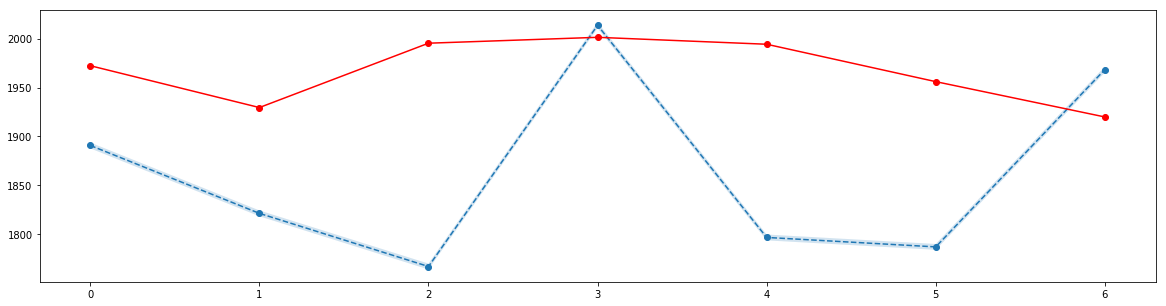

In [35]:
N = 0
D = 3
f,ax = plt.subplots(figsize = (20,5))
out = model.predict(x_test[N].reshape(1,seq_len-dout,1),).reshape(-1,1)
out = min_max_scaler.inverse_transform(out)
#U = np.ndarray.flatten(out + 2 * np.sqrt(se))
#L = np.ndarray.flatten(out - 2 * np.sqrt(se))
U = np.ndarray.flatten(out + D)
L = np.ndarray.flatten(out - D)
true = min_max_scaler.inverse_transform(y_test[N].reshape(-1,1))
print (d_Accuracy(U,L,true))
plt.fill_between(range(len(np.ndarray.flatten(out))),L,U, alpha = 0.2)
plt.plot(out,marker= 'o', linestyle='dashed')
plt.plot(true,marker= 'o', c = 'red')

### This is the complete predictions on the test set, refer to the code and try to understand how it's being predicted. High level overview is we are plotting the actual occurance with the LSTM's 7 Day predictions. So I believe this shows a fair representation of the LSTM's ability to capture trends, also the predictions are 7 day ahead so you get a somewhat idea of the strength and reliablility of prediction 1-7. This is also an excellent visualization to diagnose the model.

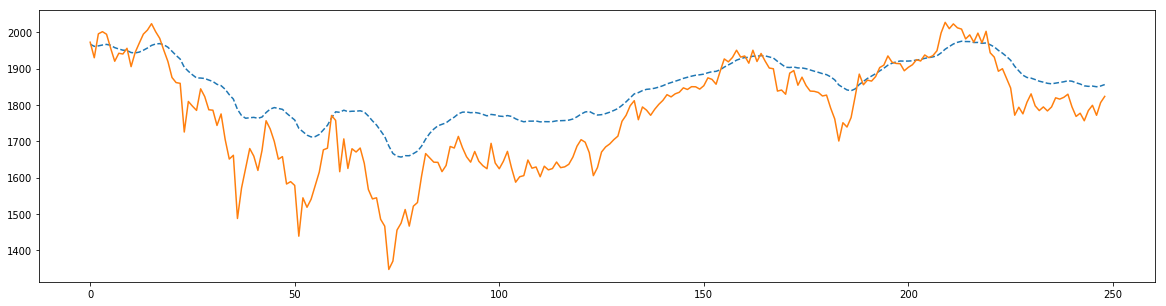

In [36]:
f,ax = plt.subplots(figsize = (20,5))
out_full = model.predict(x_test)
single = []
for i,j in enumerate(out_full):
    if i > 0:
        single.append(j[-1])       
single_ = []
for i,j in enumerate(x_test):
    if i > 0:
        single_.append(j[-1])
single = np.array(single)
single_ = np.array(single_)
single = min_max_scaler.inverse_transform(single.reshape(-1,1))
single_ = min_max_scaler.inverse_transform(single_.reshape(-1,1))
plt.plot(single, linestyle='dashed')
plt.plot(single_)
plt.show()

### This is a unseen forcast into the future, where the last known point is the latest stock record in our data base. The predicted values don't have actual values to compare against. As caution please don't make decisions solely based on the data analysis presented in this notebook, it is a guide so someone can get inspired to make this more robust. Cheers!

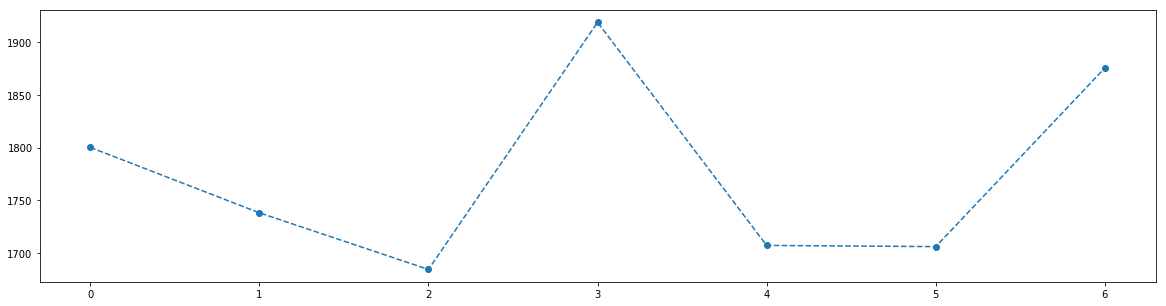

In [37]:
f,ax = plt.subplots(figsize = (20,5))
out_of_bound_  = model.predict(f_batch.reshape(1,seq_len-dout,1)).reshape(-1,1)
out_of_bound_ = min_max_scaler.inverse_transform(out_of_bound_)
plt.plot(out_of_bound_,marker= 'o', linestyle='dashed')
plt.show()